# Pipeline Visualization


In [1]:
ts              = "20260126-053521"
resource_file   = f"demo-pipeline/.nextflow/iac/{ts}/pipeline-resource-usage-{ts}.txt"
logfile         = "demo-pipeline/.nextflow.log"

cpu_per_hour = 0.025
ram_gb_per_hour = 0.0015
disk_gb_per_hour = 0.0255 / 30. / 24.

In [2]:
import pandas as pd

# The report is whitespace-delimited; using read_csv is more reliable than FWF here
try:
    metrics = pd.read_csv(resource_file, sep=r'\s+', engine='python')
    metrics.columns = metrics.columns.str.strip()
except:
    print("file not found")

metrics


,Task,CPU,LCPU,RAM(GB),DISK(GB),PEAK_RSS(GB),PEAK_VMEM(GB),CPU_TIME,CPU_GHZ,CPU_CYCLES_EST,STARTTIME(min),RUNTIME(min),%CPU,CPUAVG,%RSS,%VMEM,%DISK
0,FASTQC(SAMPLE3_SE),6,12,36,1024,0.53,40.32,0.08,2.445,195600000,0.0,0.1,174.250000,0.05,1.464430,111.989138,0.8009
1,SEQTK_TRIM(SAMPLE3_SE),2,4,12,1024,0.01,0.02,0.09,2.445,220050000,0.0,0.1,268.500000,0.33,0.076389,0.157897,0.6727
2,FASTQC(SAMPLE2_PE),6,12,36,1024,0.57,40.32,0.09,2.445,220050000,0.0,0.1,181.666667,0.06,1.579973,111.989138,0.8104
3,SEQTK_TRIM(SAMPLE2_PE),2,4,12,1024,0.01,0.02,0.10,2.445,244500000,0.0,0.1,242.750000,0.25,0.077407,0.157897,0.7152
4,FASTQC(SAMPLE1_PE),6,12,36,1024,0.53,40.32,0.08,2.445,195600000,0.0,0.1,167.666667,0.05,1.466868,111.999989,0.7855
5,SEQTK_TRIM(SAMPLE1_PE),2,4,12,1024,0.01,0.02,0.08,2.445,195600000,0.0,0.1,252.250000,0.25,0.078424,0.157897,0.6607
6,MULTIQC,1,2,6,1024,0.69,12.08,0.19,2.445,464550000,2.0,0.2,333.500000,0.17,11.535454,201.263682,0.8571


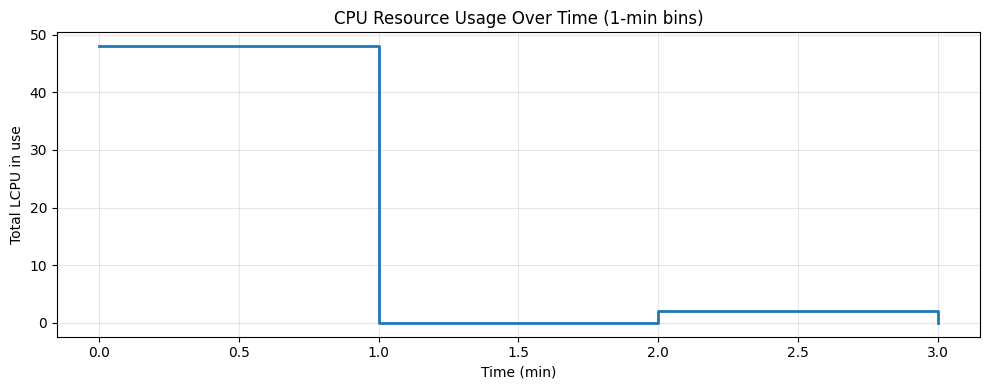

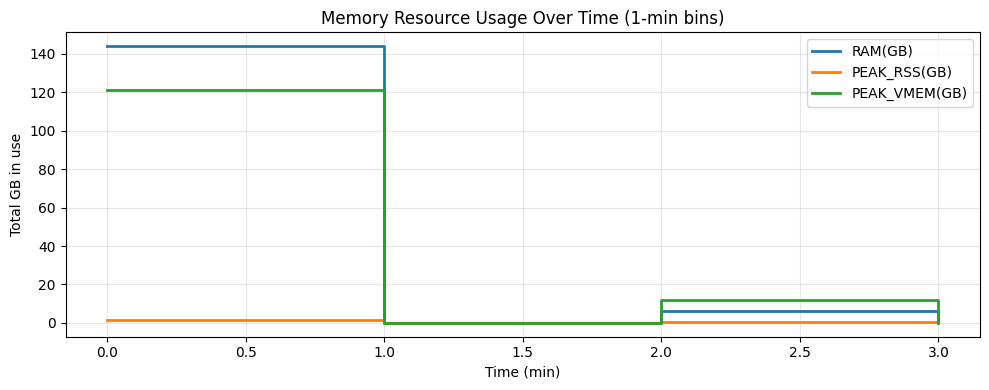

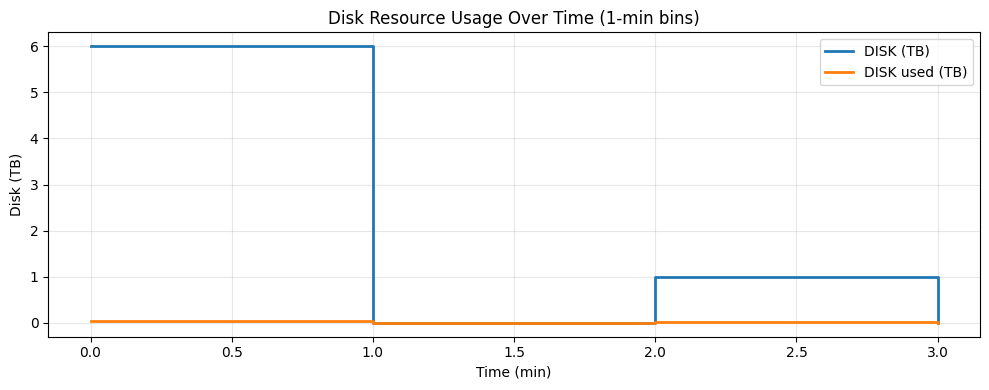

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Normalize column names
metrics.columns = metrics.columns.str.strip()

required = ['STARTTIME(min)', 'RUNTIME(min)', 'LCPU', 'RAM(GB)', 'PEAK_RSS(GB)', 'PEAK_VMEM(GB)', 'DISK(GB)']
missing = [c for c in required if c not in metrics.columns]
if missing:
    raise KeyError(f'Missing columns: {missing}. Available: {list(metrics.columns)}')

# Ensure numeric types
for col in required:
    metrics[col] = pd.to_numeric(metrics[col], errors='coerce')
if '%DISK' in metrics.columns:
    metrics['%DISK'] = pd.to_numeric(metrics['%DISK'], errors='coerce')

# Drop rows with missing time data
m = metrics.dropna(subset=['STARTTIME(min)', 'RUNTIME(min)']).copy()
m = m[m['RUNTIME(min)'] > 0]
m['start'] = np.floor(m['STARTTIME(min)']).astype(int)
m['end'] = np.ceil(m['STARTTIME(min)'] + m['RUNTIME(min)']).astype(int)

if m.empty:
    raise ValueError('No valid rows to plot after filtering numeric time fields.')

max_end = int(m['end'].max())
time = np.arange(max_end + 1)

def _bin_sum(col):
    bins = np.zeros(max_end + 1, dtype=float)
    for start, end, val in m[['start', 'end', col]].itertuples(index=False):
        if end <= start or np.isnan(val):
            continue
        bins[start:end] += val
    return bins

cpu_bins = _bin_sum('LCPU')
ram_bins = _bin_sum('RAM(GB)')
rss_bins = _bin_sum('PEAK_RSS(GB)')
vmem_bins = _bin_sum('PEAK_VMEM(GB)')
disk_resource_bins = _bin_sum('DISK(GB)')
disk_resource_bins_tb = disk_resource_bins / 1024.0

# Disk used: convert %DISK to GB using DISK(GB) as capacity
if '%DISK' in m.columns:
    m['DISK_USED_GB'] = m['DISK(GB)'] * (m['%DISK'] / 100.0)
else:
    m['DISK_USED_GB'] = np.nan
disk_used_bins = _bin_sum('DISK_USED_GB')
disk_used_bins_tb = disk_used_bins / 1024.0

plt.figure(figsize=(10, 4))
plt.step(time, cpu_bins, where='post', linewidth=2)
plt.xlabel('Time (min)')
plt.ylabel('Total LCPU in use')
plt.title('CPU Resource Usage Over Time (1-min bins)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.step(time, ram_bins, where='post', linewidth=2, label='RAM(GB)')
plt.step(time, rss_bins, where='post', linewidth=2, label='PEAK_RSS(GB)')
plt.step(time, vmem_bins, where='post', linewidth=2, label='PEAK_VMEM(GB)')
plt.xlabel('Time (min)')
plt.ylabel('Total GB in use')
plt.title('Memory Resource Usage Over Time (1-min bins)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.step(time, disk_resource_bins_tb, where='post', linewidth=2, label='DISK (TB)')
if not np.isnan(disk_used_bins).all():
    plt.step(time, disk_used_bins_tb, where='post', linewidth=2, label='DISK used (TB)')
plt.xlabel('Time (min)')
plt.ylabel('Disk (TB)')
plt.title('Disk Resource Usage Over Time (1-min bins)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
